# Mini-project IIa: Model selection basics

## Physics 8805 -- Learning from Data: Bayesian Methods and Machine Learning
### Autumn, 2019

Adapted from Christian Forssen, TALENT Course 11, June, 2019.
$% Some LaTeX definitions we'll use.
\newcommand{\pr}{\textrm{p}}
$

**For this part of mini-project II, your task is simply to work through this notebook and answer the questions, modifying the code as needed.** 

### Bayesian evidence: 
Please see the notes for Lecture 14 for background and the discussion of "The story of Dr. A and Prof. B from Sivia's book. There is also a summary of Laplace's method for approximating evidence factors.

### Import of modules

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set("talk")  # for plot formatting

from scipy import optimize

## What order polynomial?

Throughout the rest of this section, we will use data that was generated from a "true model" where x and y satisfy the following:

$$
y_i = x_i \sin(x_i)+\epsilon_i, 
$$

where $0 \leq x_i \leq 3$ and the noise is drawn from a normal distribution $\epsilon_i \sim \mathcal{N}(0, \sigma_0)$. The values for 20 regularly spaced points with $\sigma_0=0.1$ are shown below.

In [2]:
#------------------------------------------------------------
# Define our functional form
def true_func(x):
    """The true function behind the data."""
    return np.sin(x) * x

def func(x, dy):
    """Returns the true function evaluated at x with Gaussian noise
        with standard deviation dy.
    """
    return np.random.normal(true_func(x), dy)

#------------------------------------------------------------
# generate the (noisy) data
np.random.seed()  # Use np.random.seed() for new random numbers.
                  # Use np.random.seed(42) for repeatable random numbers.

num_data = 20           # number of data points
x_min = 0; x_max = 3.   # specify the data range

# Build x and y arrays with noisy data
x = np.linspace(x_min, x_max, num_data+2)[1:-1]  # exclude end points
sig0 = 0.1  # Later: try 0.5 or higher or 0.01
y = func(x, sig0)

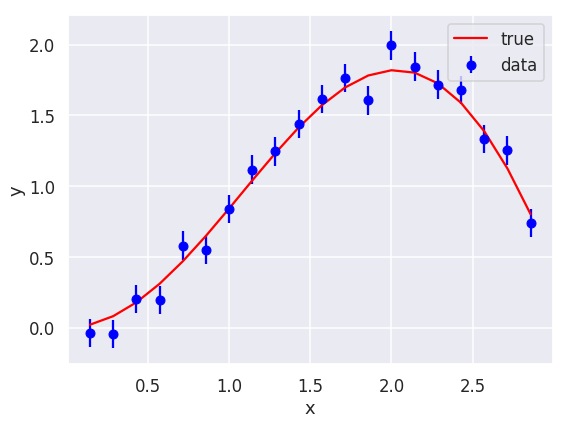

In [3]:
# Plot the current data set
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.errorbar(x, y, sig0, fmt='o', color='blue', label='data');
ax.plot(x, true_func(x), color='red', label='true')
ax.set(xlabel='x',ylabel='y')
ax.legend()
fig.tight_layout()

Assume that we have a multiple of models, with varying degree of sophistication. In this example we use *polynomials* of different orders to represent models of increasing complexity and with an increasing number of model parameters.

> Our task is to find which model finds the most support in the *given* data.

It is clear that a more complicated model with more free parameters should be able to fit the data much more closely. But what is the **evidence** in the data for such a complicated model? Finding the answer to this question is a task for a Bayesian, and the problem is generally known as *Model selection*. 

Below, we will use an approximate way of computing the Bayesian evidence, namely the Laplace method. In some cases one can also use conjugate priors to simplify the computation of the evidence factor. Or one can use certain sampling methods to compute the evidence numerically (this is generally quite difficult; we will try it in Mini-project 2b). The highlight will be the comparison of different models using the evidences to extract odds-ratios. 

### The Model

See previous lecture notes, in particular Lectures 10 and 11, for some more details.

In general, we're fitting a $M$-degree polynomial to data, 

$$
y_M(x) = \sum_{i=0}^M \theta_i x^i
$$

where we use $\theta$ to denote our parameter vector of length $M+1$.

Assuming all the points are independent, we can find the full log likelihood by adding the individual likelihoods together:
$$
\begin{align}
\log p(D\mid\theta, I) &= -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\sigma_0^2) + \frac{\left[ y_i - y_M(x_i;\theta)\right]^2}{\sigma_0^2}\right) \\
&= \text{constant} - \sum_{i=1}^N \frac{\left[ y_i - y_M(x_i;\theta)\right]^2}{2 \sigma_0^2}
\end{align}
$$

We often define the residuals
$$
R_i = \left[ y_i - y_M(x_i;\theta) \right]/\sigma_0,
$$
so that the relevant chi-square sum reads $- \sum_{i=1}^N R_i^2 / 2$.

In [4]:
def residuals(theta, x=x, y=y, sigma0=sig0):
    """Calculate residuals using the numpy function polyval"""
    dy = y - np.polyval(theta, x)
    return dy / sigma0

def log_likelihood(theta):
    """ Standard likelihood with Gaussian errors as specified using defaults.
        Uniform prior for theta is implied.
    """
    return -0.5 * np.sum(residuals(theta)**2)

### Maximum likelihood fits

We can maximize the likelihood to find $\theta$ within a frequentist paradigm. Let us start with a linear fit:

In [5]:
degree = 1
# The numpy polyfit function fits a least squares polynial to given data.
#  Using different weights at different x points is an option, but not used
#  here just because we have constant sigma.
theta_hat = np.polyfit(x, y, degree)

x_fit = np.linspace(0, x_max, 1000)
y_fit = np.polyval(theta_hat, x_fit)

Rather than just plotting this fit, we will compare several different models in the figure below.

degree  chi^2/dof
  0       41.285
  1       19.694
  2        4.612


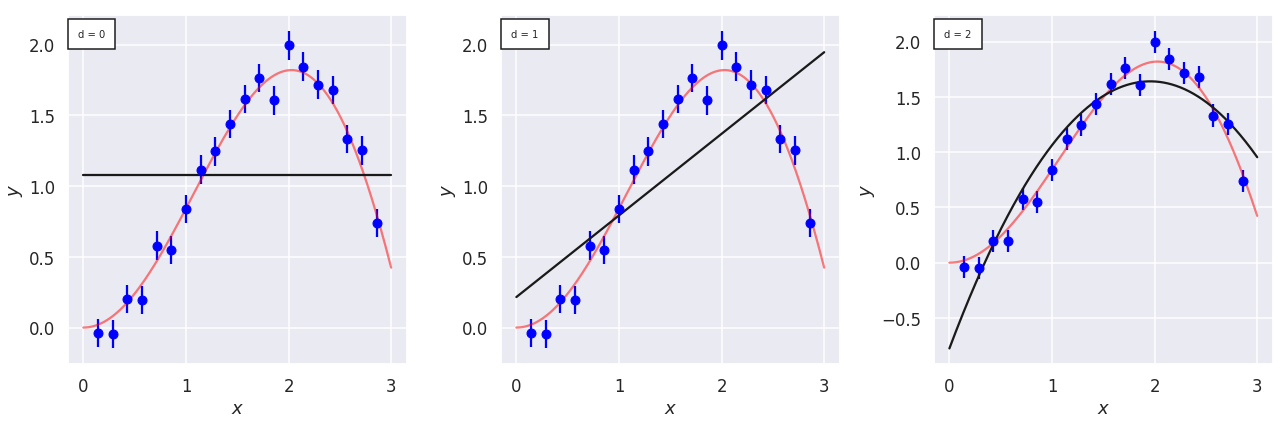

In [6]:
def fit_degree_n(degree, ax):
    """Fit a polynomial of order 'degree', return the chi-squared, 
       and plot in axes 'ax'.
    """
    theta_hat = np.polyfit(x, y, degree)
    x_fit = np.linspace(x_min, x_max, 1000)
    y_fit = np.polyval(theta_hat, x_fit)
    
    
    ax.errorbar(x, y, sig0, fmt='o', color='blue')  # data
    ax.plot(x_fit, true_func(x_fit), color='red', alpha=.5)  # true function
    
    # add an annotation for the degree of the polynomial fit to the data
    ax.text(0.03, 0.96, f"d = {degree}", transform=plt.gca().transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w', pad=10))
    
    ax.plot(x_fit, y_fit, '-k')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$');
    
    return -2. * log_likelihood(theta_hat)  # chi_squared

#------------------------------------------------------------
# First figure: plot points with a linear fit
nrows = 1; ncols = 3;    
fig = plt.figure(figsize=(6*ncols, 6*nrows))  # scale figure space

num_plots = nrows * ncols
degrees = np.zeros(num_plots, dtype=int)
chi_sqs_dof = np.zeros(num_plots)
print('degree  chi^2/dof')
for i in range(num_plots):
    ax = fig.add_subplot(nrows, ncols, i+1)
    degrees[i] = i
    dof = len(x) - (degrees[i])
    chi_sqs_dof[i] = fit_degree_n(i, ax) / dof 
    print(f'  {degrees[i]:d}     {chi_sqs_dof[i]:8.3f}')
fig.tight_layout()

### Things to do and Questions to answer

* Change the degree of the polynomial that is used for the fit so that the multi-panel figure is 3 by 3.
<br><br>


* Plot the computed chi-squared value per degree of freedom as a function of the degree of the polynomial. Is it decreasing, or is there a peak?  How do you interpret the result?
<br><br>


* For which degree polynomials would you say that you're underfitting the data?
<br><br><br>

* For which degree polynomials would you say that you're overfitting the data?
<br><br><br>


## Bayesian evidence

Let us try the Bayesian approach and actually compute the evidence for these different models. We will use the Laplace method for computing the norm of the posterior distribution (i.e. approximating it as a single Gaussian).

We use simple uniform priors for the model parameters:
$$
p(\theta_i|I) = \left\{
\begin{array}{ll}
\frac{1}{\theta_\mathrm{max} - \theta_\mathrm{min}} & \text{for } \theta_\mathrm{min} \leq \theta_i \leq \theta_\mathrm{max}, \\
0 & \text{otherwise},
\end{array}
\right.
$$
which means that the posterior will be
$$
p(\theta | D, I) = \frac{1}{(\theta_\mathrm{max} - \theta_\mathrm{min})^K} \frac{1}{\sqrt{(2\pi)\sigma_0^2}^N} \exp\left( -\chi^2 / 2\right),
$$
within the allowed prior region for the $K$ parameters and zero elsewhere.

Assuming that the peak of the Gaussian is located at $\theta^*$, well inside the prior region; we can easily approximate the integral
$$
Z_p = \int d^K\theta\, p(\theta | D, I),
$$
using Laplace's method (see Lecture 14 notes). With this particular choice of prior, and again under the assumption that the cut at the edges does not change the integral over the multidimensional integral, we get
$$
Z_p \approx \frac{1}{(\theta_\mathrm{max} - \theta_\mathrm{min})^K} \exp\left( -\chi^2(\theta^*) / 2\right) \frac{\sqrt{(2\pi)^K}}{\sqrt{\det(\Sigma^{-1})}},
$$
where $\Sigma^{-1}_{ij} = \partial^2\chi^2/\partial \theta_i \partial \theta_j$ (i.e. the Hessian) evaluated at the maximum $\theta^*$. We removed the constant factor $\sqrt{(2\pi)\sigma_0^2}^N$ since it will be the same for all models. 

Note that for this linear regression problem we can get all these quantities ($\theta^*$, $\Sigma$) via linear algebra. See, e.g., the Lecture 11 notes or Hogg's nice paper: [Data analysis recipes: Fitting a model to data](https://arxiv.org/abs/1008.4686). Below, we will use `numpy.polyfit` to extract the relevant quantities.

In [7]:
# We use a uniform prior for all parameters in [theta_min, theta_max]
theta_max = 1000
theta_min = -1000
prior_range = theta_max - theta_min

In [8]:
degree_max = 8
evidence = np.zeros(degree_max+1)
print("Degree  P*          Best fit parameters: ")
for ideg,deg in enumerate(range(degree_max+1)):
    theta_hat, Cov = np.polyfit(x, y, deg, cov='unscaled')
    if not (np.all(theta_hat < theta_max) and np.all(theta_hat > theta_min)):
        print("Outside of prior range")
    P_star = np.exp(log_likelihood(theta_hat))
    H = np.linalg.inv(Cov)
    evidence[ideg] = P_star * np.sqrt((2*np.pi)**deg / np.linalg.det(H)) / prior_range**deg
    print (f'   {deg}    {P_star:.2e}  ',('{:5.2f} '*len(theta_hat)).format(*theta_hat))

Degree  P*          Best fit parameters: 
   0    5.01e-180    1.08 
   1    5.56e-82    0.58  0.22 
   2    9.37e-19   -0.63  2.47 -0.78 
   3    1.03e-03   -0.43  1.30  0.09 -0.11 
   4    1.08e-03    0.02 -0.57  1.57 -0.10 -0.08 
   5    1.11e-03   -0.02  0.19 -1.02  2.11 -0.35 -0.04 
   6    1.13e-03   -0.03  0.21 -0.59  0.27  1.06  0.01 -0.08 
   7    1.21e-03   -0.09  0.91 -3.73  7.82 -9.41  6.86 -1.57  0.06 
   8    1.23e-03   -0.05  0.57 -2.34  4.84 -5.11  1.80  1.56 -0.38 -0.03 


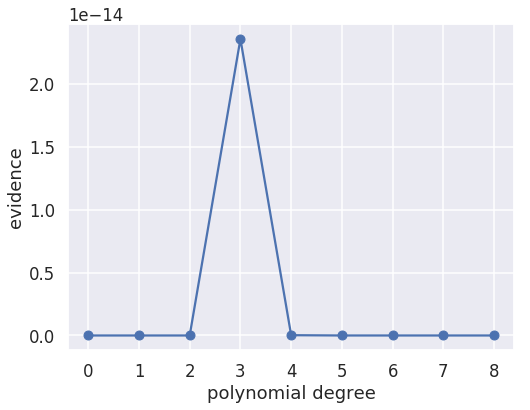

In [9]:
# plot the evidence

d = np.arange(0, degree_max+1)

fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(d,evidence,'o-')

ax.set_xlabel('polynomial degree')
ax.set_ylabel('evidence');

### Explorations:  Things to do and Questions to answer

* Can you see the transition from underfit to overfit in the figures?
<br><br>
* What would you say is the degree of polynomial that is supported by the data?
<br><br>
* Describe the results after you change the number of the generated data? E.g., try `num_data` = 10.
<br><br>
* Describe the results after you change the range of the generated data?  E.g., try `x_max` = 1.
<br><br>
* Describe the results after you change the error of the generated data?  E.g., try `sig0` = 0.5.
<br><br>


We see sensitivity to the prior in the peak of the evidence with the degree of the polynomial in our model.  What about the scale-invariant prior advocated by [Minka](https://tminka.github.io/papers/minka-linear.pdf)?  Another possibility advanced by Trotta (Bayes in the sky) is a multi-normal Gaussian distribution with zero mean and Fisher information matrix as covariance. These are worth trying (but you don't need to do them for Mini-Project IIa).  

#### Odds-ratios
Quoting the well-known paper by Trotta:
[Bayes in the sky: Bayesian inference and model selection in cosmology](https://arxiv.org/abs/0803.4089) we can quantify an empirical scale for evaluating the strength of evidence when comparing two models:
![Bayes in the Sky](trotta.png)

Here, the ratio of the evidences of model $M_0$ and $M_1$ is given by,
\begin{equation}
 \label{eq:Bayes_factor}
 B_{01} = \frac{p(\mathrm{data} | M_0)}{p(\mathrm{data} | M_1)} \; ,
\end{equation}
which is also called _Bayes factor_. That means $|\ln B_{01}| \equiv |\ln p(\mathrm{data} | M_0) - \ln p(\mathrm{data} | M_1)|$ is the relevant quantity for estimating the strength of evidence of the two models (see first and last column of the table).

### Question

* Below we have created a table of odds-ratios between pairs of the different-order polynomial models, given that the ratio of prior probabilities for the different models is unity.  Interpret the table based on Trotta's chart. 
<br>
<br>

In [10]:
# Odds ratio table
print('Calculating the logarithm of the Bayes ratio of degree n to n+1')
print('  n   n+1   log(Bn,n+1)')
for ideg,deg in enumerate(range(degree_max)):
    odds_ratio = evidence[ideg] / evidence[ideg+1]
    print(f'  {deg}   {deg+1}      {np.abs(np.log(odds_ratio)):.2f}')


Calculating the logarithm of the Bayes ratio of degree n to n+1
  n   n+1   log(Bn,n+1)
  0   1      217.77
  1   2      137.91
  2   3      27.29
  3   4      6.95
  4   5      6.61
  5   6      6.24
  6   7      5.78
  7   8      5.42


## Bonus:  Do this section for a plus

### Cross validation
This section will introduce the frequentist tool of cross-validation. This approach is used extensively within machine-learning as a way to handle overfitting and underfitting, bias and variance.

In [11]:
# Select the cross-validation points
ncross=5
index_cv = np.random.choice(range(len(x)), ncross, replace=False)

x_cv=x[index_cv]
y_cv=y[index_cv]

In [12]:
# The training data is then
x_train = np.delete(x,index_cv)
y_train = np.delete(y,index_cv)

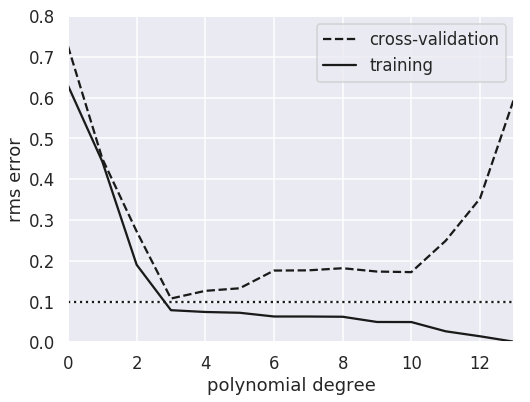

In [13]:
# Plot training and CV errors as a function of polynomial degree d
degree_max = 13
d = np.arange(0, degree_max+1)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig,ax = plt.subplots(figsize=(8, 6))
for i in range(len(d)):
    p = np.polyfit(x_train, y_train, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x_train) - y_train) ** 2)
                              / len(y_train))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)
                              / len(y_cv))

ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, sig0 * np.ones(d.shape), ':k')

ax.set_xlim(0, degree_max)
# You might need to change the y-scale if you make modifications to the training data
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc='best');


### Answer these questions

* Can you see the transition from underfit to overfit in this figure?
<br><br>
* What would you say is the degree of polynomial that is supported by the data?
<br><br>
* Try changing the size of the cross-validation and training sets. Does the conclusions become more/less clear?
<br><br>
* Do the results change between different runs with the same number of CV samples? If so, why?
<br><br>
* K-fold cross validation is a popular variant of CV. It addresses some issues with the sensitivity to the actual choice of which data is used for training and validation.  What do you think that it means, and what is the possible drawback if you have a computational expensive model?
<br><br>
* Leave-one-out is another variant. For linear regression problems, this type of cross-validation can actually be performed without having to do multiple fits. What do you think that it means?
<br><br>
* It is common to divide the data into a training set, a cross-validation set, and a test set. What do you think is the purpose of having three different sets?
<br><br>
